<a href="https://colab.research.google.com/github/Ejeus/Android/blob/master/CV_EE_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We import Libraries
Expected Output:
A message indicating installation and successful imports of TensorFlow, SHAP, LIME, and other libraries.

In [ ]:
# Step 1. Setup and Import Libraries
# This cell installs and imports necessary libraries including TensorFlow/Keras, scikit-learn, SHAP, LIME, and additional utilities.
# Run this cell to install any missing packages.

!pip install tensorflow
#==2.10.0  # or latest TF version
!pip install shap
!pip install lime

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("Libraries imported successfully.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5434a790db65de3f27e95d2b998734a7a5f6bc77681013fb98be6b0c9353ccb4
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Libraries imported successfully.


In [ ]:
# Step 2. Mount Google Drive & Set Up Dataset Paths
# We assume your dataset is stored on Google Drive (under a folder named `emotion_dataset`) with subfolders for each emotion.
# In this cell, we mount the drive and set the dataset path.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your dataset paths
# You can replace the drive path if using a local copy by adjusting dataset_dir_local.
dataset_dir_drive = '/content/drive/MyDrive/emotion_dataset'
dataset_dir_local = '/content/emotion_dataset'  # if you uploaded manually

# Verify dataset structure
print("Dataset folder (from drive):", os.listdir(dataset_dir_drive))


Mounted at /content/drive
Dataset folder (from drive): ['contentment', 'anger', 'amusement', 'awe', 'sadness', 'disgust', 'excitement', 'fear']


In [ ]:
# Step 3. Data Preprocessing using ImageDataGenerator
# We use Keras's ImageDataGenerator to load images from subdirectories for training and validation.
# The generator automatically labels images based on folder names.

# Define image size, batch size and data augmentation parameters.
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,  # 80:20 training-validation split
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir_drive,  # use dataset_dir_local if needed
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir_drive,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("Training and validation generators are ready.")


Found 18559 images belonging to 8 classes.
Found 4636 images belonging to 8 classes.
Training and validation generators are ready.


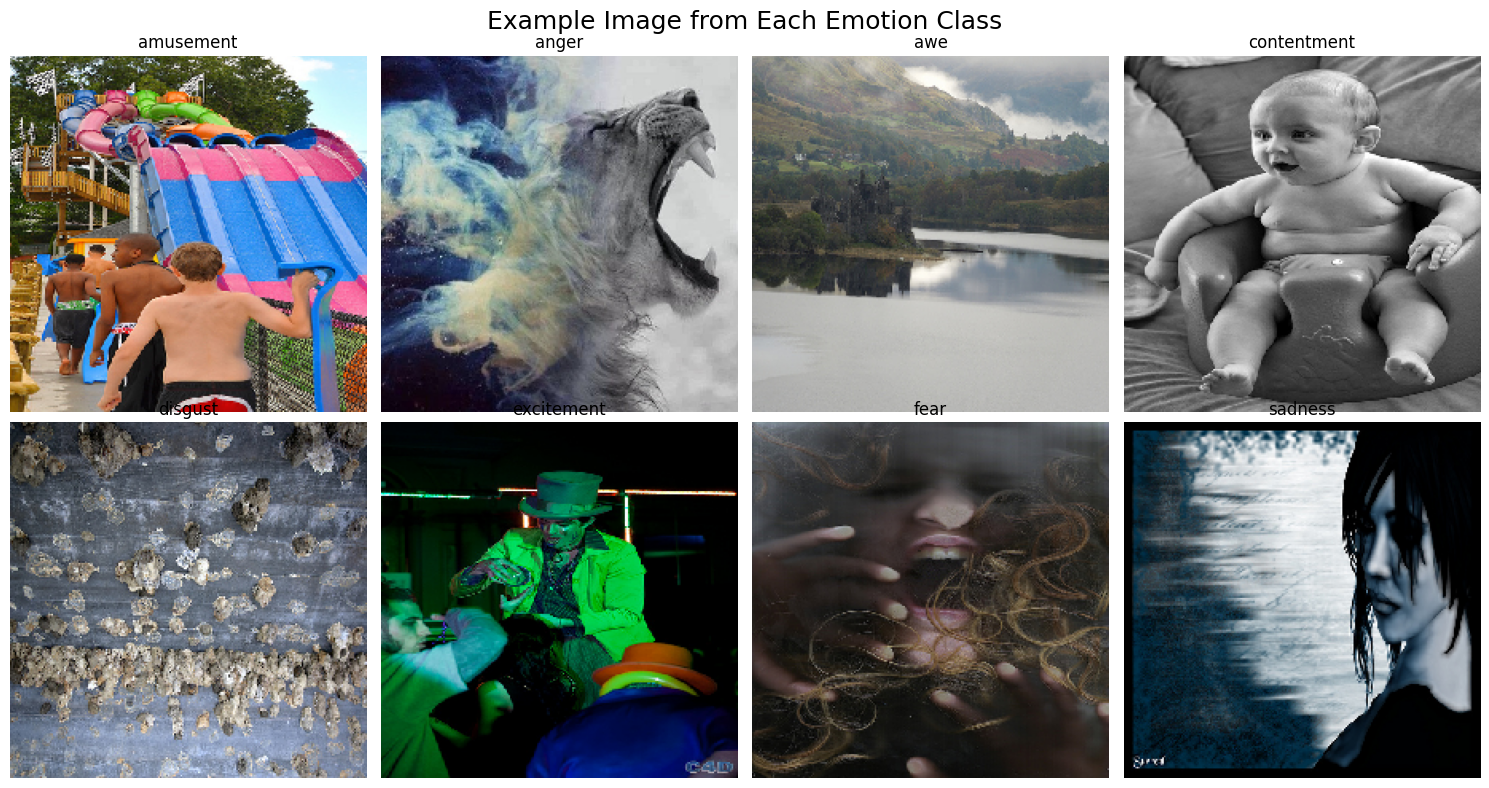

In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
#import os
#from tensorflow.keras.preprocessing import image

# Get mapping from class indices to class labels
emotion_labels = {v: k for k, v in train_generator.class_indices.items()}

# Base directory containing emotion subfolders (same as used in flow_from_directory)
base_dir = train_generator.directory

# Dimensions used for model input
IMG_HEIGHT, IMG_WIDTH = train_generator.target_size

# Plot one image per emotion class
plt.figure(figsize=(15, 8))

for class_idx, class_name in emotion_labels.items():
    class_dir = os.path.join(base_dir, class_name)
    image_name = os.listdir(class_dir)[0]  # take the first image in this folder
    image_path = os.path.join(class_dir, image_name)

    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0

    plt.subplot(2, 4, class_idx + 1)
    plt.imshow(img_array)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Example Image from Each Emotion Class", fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
# Images per emotion class
import os
from collections import defaultdict

# Path to your dataset directory (same used in flow_from_directory)
base_dir = train_generator.directory

# Count images per class
emotion_counts = defaultdict(int)

for emotion in os.listdir(base_dir):
    emotion_dir = os.path.join(base_dir, emotion)
    if os.path.isdir(emotion_dir):
        image_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        emotion_counts[emotion] = len(image_files)

# Print results
print("Number of images per emotion:")
for emotion, count in sorted(emotion_counts.items()):
    print(f"{emotion}: {count}")


Number of images per emotion:
amusement: 4923
anger: 1255
awe: 3133
contentment: 5356
disgust: 1657
excitement: 2924
fear: 1046
sadness: 2901


Data Quality and Preprocessing Enhancements

Image Quality Assessment: Add an automated routine to assess and filter out images that are too blurred or misaligned.

Automated Data Labeling Correction: Consider incorporating a tool that detects and flags mislabeled images.

Provides a simple pre-filtering step to remove images that are unlikely to contribute positively to training

In [ ]:
# Filtering images based on brightness (as a proxy for quality)
def filter_images_based_on_brightness(image_path, threshold=50):
    import cv2
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    brightness = np.mean(image)
    return brightness > threshold

# Loop through dataset folders and print low quality image names
for emotion in os.listdir(dataset_dir_drive):
    folder = os.path.join(dataset_dir_drive, emotion)
    for file in os.listdir(folder):
        if not filter_images_based_on_brightness(os.path.join(folder, file)):
            print(f"Low brightness image: {os.path.join(folder, file)}")


Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4554.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4556.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4564.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4678.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4708.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4779.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4835.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4849.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4928.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset/contentment/contentment_4950.jpg
Low brightness image: /content/drive/MyDrive/emotion_dataset

In [ ]:
# Step 4. Create a Transfer Learning Model Using VGG16
# We load the VGG16 model without the top classification layers and add our custom layers for emotion classification.
# The base layers are frozen to leverage the pre-trained weights, and new layers are added and trained.

# Load the VGG16 model without the top classifier layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model weights

# Add custom classification layers on top of the base model.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Construct the full model.
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981,448 (57.15 MB)

 Trainable params: 266,760 (1.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Monitoring and Logging

Integrate a logging framework such as TensorBoard or Weights & Biases (wandb) to monitor training progress, losses, and evaluation metrics.

*   Enables you to visualize loss curves, accuracy trends, and model graphs during training using TensorBoard.
*   This makes debugging and model optimization more straightforward.



In [ ]:
# Step 5. Train the Model
# Here we train our model using the generators defined earlier.
# We set up callbacks such as ModelCheckpoint to save the best model during training.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("emotion_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
#using TensorBoard to track training
#log_dir = "logs/fit/"
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=1,  # 15 Adjust based on your dataset size and convergence
    callbacks=[checkpoint, early_stop]
    #callbacks=[checkpoint, early_stop, tensorboard_callback]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/579 ━━━━━━━━━━━━━━━━━━━━ 2:23:14 21s/step - accuracy: 0.2278 - loss: 5.7187

In [2]:
# Step 6. Evaluate the Trained Model
# We load the best saved model and evaluate its performance on the validation set.
model = load_model("emotion_model.h5")
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss: {:.4f}".format(loss))
print("Validation Accuracy: {:.4f}".format(accuracy))


NameError: name 'load_model' is not defined

In [ ]:
# Step 7. Unsupervised Learning: Clustering on Features Extracted from VGG16
# In addition to supervised classification, we use unsupervised clustering on image features.
# We extract features from the VGG16 base model (before the custom dense layers) and apply PCA for dimensionality reduction followed by KMeans clustering.

# Create a feature extractor model from the base VGG16
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, num_images=1000):
    features = []
    labels = []
    count = 0
    for batch_images, batch_labels in generator:
        batch_features = feature_extractor.predict(batch_images)
        # Flatten the features
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features)
        labels.append(batch_labels)
        count += batch_images.shape[0]
        if count >= num_images:
            break
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features from 1000 images from the training data
features, labels = extract_features(train_generator, num_images=1000)
print("Extracted features shape:", features.shape)

# Use PCA to reduce dimensionality to 50 dimensions
pca = PCA(n_components=50)
features_reduced = pca.fit_transform(features)
print("Reduced feature shape after PCA:", features_reduced.shape)

# Cluster with KMeans into 8 clusters (corresponding to 8 emotions)
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(features_reduced)
print("Cluster labels:", np.unique(clusters))


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(5, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)


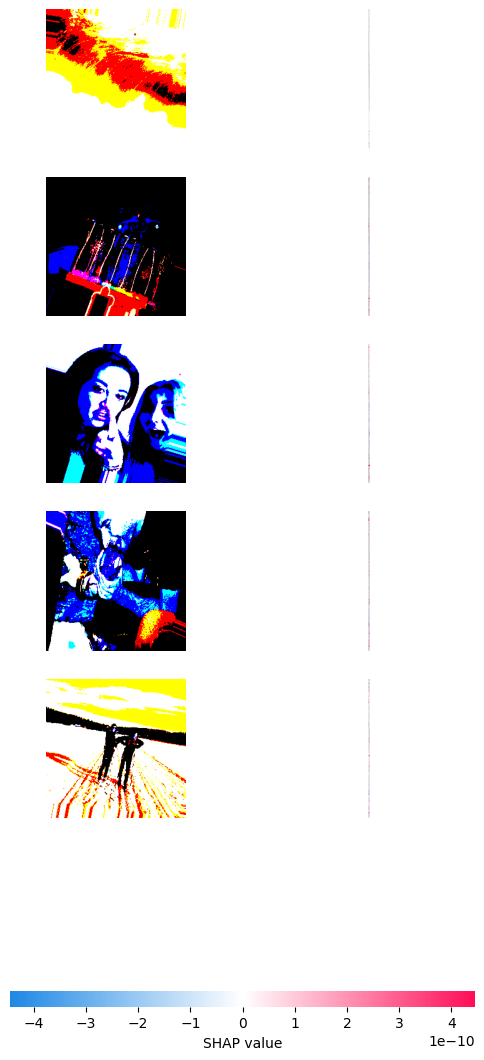

In [ ]:
# Step 8. Model Interpretability with SHAP
# We use SHAP DeepExplainer to explain the predictions made by our trained model.
# Select a sample of images from the validation set.

# Get a batch of images and true labels from validation set
batch_images, batch_labels = next(validation_generator)
sample_images = batch_images[:5]  # analyzing 5 images for demonstration

# Create a SHAP explainer; for deep learning, we use DeepExplainer.
# Note: For complex models, this can be computationally expensive.
explainer = shap.DeepExplainer(model, sample_images)
shap_values = explainer.shap_values(sample_images)

# Visualize the explanations for the first emotion class for each sample
shap.image_plot(shap_values[0], sample_images)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

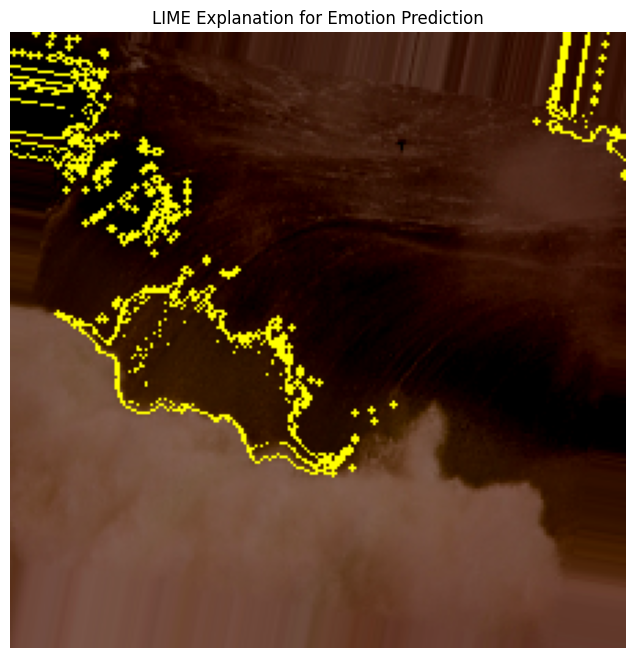

In [ ]:
# Step 9. Model Interpretability with LIME
# We use LIME to understand which parts of an image influenced the model's prediction.
# We define a prediction function and use the lime_image explainer.

def predict_fn(images):
    # Preprocess the images as expected by our model
    images_preprocessed = preprocess_input(images)
    return model.predict(images_preprocessed)

# Use a sample image for explanation (first image from validation batch)
test_image = sample_images[0]
explainer_lime = lime_image.LimeImageExplainer()
explanation = explainer_lime.explain_instance(test_image.astype('double'),
                                              predict_fn,
                                              top_labels=5,
                                              hide_color=0,
                                              num_samples=1000)

# Get explanation for the top predicted label
top_pred_label = np.argmax(predict_fn(np.expand_dims(test_image, axis=0)))
temp, mask = explanation.get_image_and_mask(top_pred_label, positive_only=True, num_features=5, hide_rest=False)

# Visualize the explanation using mark_boundaries (requires skimage)
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation for Emotion Prediction")
plt.axis('off')
plt.show()


In [ ]:
# Step 10. Inference on New / Uploaded Images
# This cell shows how to load and preprocess a new image (from local upload or social media dump) and use our trained model to classify the emotion.
# This same approach can be used to analyze images scraped from Twitter, Instagram, or any social media platform.

from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload an image file
uploaded = files.upload()

for fn in uploaded.keys():
    # Load image and resize to target size
    img_path = fn
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    # Predict the emotion
    predictions = model.predict(img_preprocessed)
    predicted_class = np.argmax(predictions, axis=1)

    # Mapping class indices back to emotion names
    emotion_labels = {v: k for k, v in train_generator.class_indices.items()}
    emotion = emotion_labels[predicted_class[0]]

    # Display the image and prediction
    plt.imshow(img)
    plt.title("Predicted Emotion: {}".format(emotion))
    plt.axis('off')
    plt.show()
    print("Model probabilities:", predictions)


Saving IMG-20240806-WA0016.jpg to IMG-20240806-WA0016.jpg


NameError: name 'IMG_HEIGHT' is not defined

In [ ]:
# Step 11. Analysis for Social Media Images
# The same pipeline can be applied to images collected from social media platforms (e.g., Twitter or Instagram).
# Typically, you might need to add an extra step to download these images via APIs (Tweepy for Twitter, etc.),
# then save them locally and run them through the same preprocessing and prediction pipeline.

# Example (Pseudo-code):


1. Advanced Model Evaluation

a. Confusion Matrix and Classification Report

Evaluating our model with a confusion matrix and detailed classification report is very useful for understanding class-wise performance. The code below computes and visualizes a confusion matrix using scikit-learn:

*   It extracts predictions and true labels from your validation data.
*   Computes and plots a confusion matrix.
*   Provides a classification report with precision, recall, and F1-score for each emotion class.



In [ ]:
# Evaluate model predictions on the validation set for a detailed report
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions and true labels from the validation generator
val_steps = validation_generator.samples // BATCH_SIZE
predictions = model.predict(validation_generator, steps=val_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[:len(predicted_classes)]
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)


 41/144 ━━━━━━━━━━━━━━━━━━━━ 34:55 20s/step

KeyboardInterrupt: 

b. ROC Curve and AUC (for Multi-Class)

Although ROC curves are typically designed for binary classification, you can compute a one-vs-all ROC curve for multi-class problems. For example:

*   Binarizes labels to handle the multi-class scenario.
*   Computes ROC curves and AUC for each emotion class.
*   Visualizes the one-vs-all ROC curves to gauge the performance of each class separately.





In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the true labels for multi-class evaluation
y_true_bin = label_binarize(true_classes, classes=range(len(class_labels)))
n_classes = y_true_bin.shape[1]
y_score = predictions

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curves')
plt.legend(loc="lower right")
plt.show()


NameError: name 'true_classes' is not defined

2. Model Interpretability: Grad-CAM

Grad-CAM (Gradient-weighted Class Activation Mapping) helps visualize which regions of an image contribute most to the prediction. This is an alternative to LIME/SHAP and is highly popular in computer vision. The code below demonstrates how to compute Grad-CAM for your model:

*   Extracts the gradients from the last convolutional layer.
*   Computes a weighted heatmap of pixel activations.
*   Overlays the heatmap onto the original image to show influential regions



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


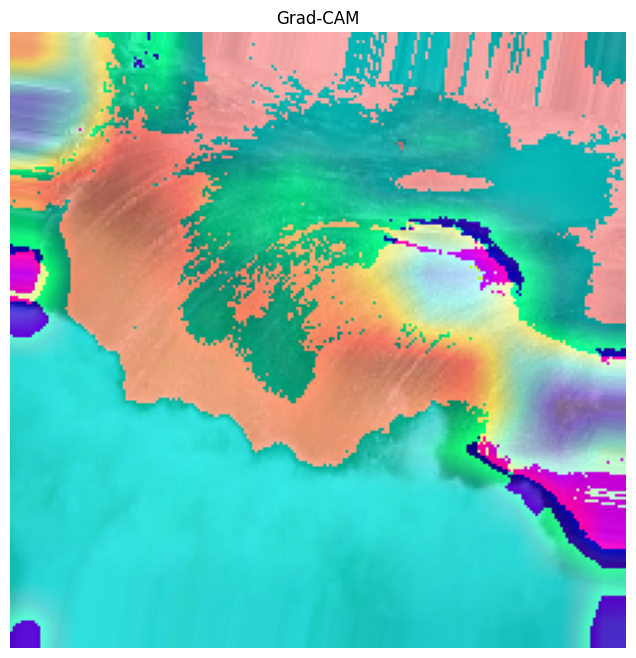

In [ ]:
# Grad-CAM implementation to visualize which regions in the image are most influential
import cv2
import tensorflow.keras.backend as K

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Get the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = np.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Select an image from validation data and generate Grad-CAM
img = sample_images[0]  # using the sample from previous code
img_array = np.expand_dims(img, axis=0)
heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name='block5_conv3')  # VGG16's last conv layer

# Visualize heatmap overlay on the original image
heatmap_resized = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img.astype('uint8')
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img.astype('uint8'))
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


3. Hyperparameter Tuning Using Keras Tuner

Finding the optimal hyperparameters can significantly enhance model performance. The code below uses Keras Tuner to search for the best learning rate, dropout rate, and the number of neurons in a dense layer:

*   Defines a model-building function with hyperparameters for dense units, dropout, and learning rate.
*   Uses Keras Tuner’s random search strategy to explore hyperparameter space.
*   Trains multiple models and then selects the best performing model based on validation accuracy.



In [ ]:
!pip install keras-tuner

import keras_tuner as kt

def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    hp_units = hp.Int('units', min_value=256, max_value=1024, step=128)
    x = Dense(hp_units, activation='relu')(x)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)
    x = Dropout(hp_dropout)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    hp_lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='emotion_tuning',
    project_name='emotion_recognition'
)

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=5,
             steps_per_epoch=train_generator.samples // BATCH_SIZE,
             validation_steps=validation_generator.samples // BATCH_SIZE)

best_model = tuner.get_best_models(num_models=1)[0]
print("Best hyperparameters:", tuner.get_best_hyperparameters(1)[0].values)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
768               |768               |units
0.3               |0.3               |dropout
3.3775e-05        |3.3775e-05        |learning_rate

Epoch 1/5
  2/579 ━━━━━━━━━━━━━━━━━━━━ 3:11:11 20s/step - accuracy: 0.1172 - loss: 5.9000

KeyboardInterrupt: 

4. Data Augmentation Using GANs (Optional)

If you need more training data, you can use Generative Adversarial Networks (GANs) to create synthetic facial expressions for underrepresented emotion classes. Below is a very high-level outline of how you might approach this with a conditional GAN:


*   Provides a high-level outline of building a conditional GAN for augmenting your dataset.
*   The generator creates synthetic images conditioned on an emotion label.
*   The discriminator evaluates whether an image is real or synthetic.
*   While this is not a complete training script for a GAN, it points you toward a proven strategy for data augmentation.



In [ ]:
# High-level code for data augmentation using a conditional GAN (cGAN)
# This is a simplified example; real-world implementation would require more tuning.

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Concatenate, Embedding, LeakyReLU
from tensorflow.keras.models import Sequential

latent_dim = 100
num_classes = train_generator.num_classes

# Generator model
def build_generator():
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, latent_dim)(label)
    label_embedding = Flatten()(label_embedding)

    model_input = Concatenate()([noise, label_embedding])
    x = Dense(256 * 7 * 7, activation='relu')(model_input)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    img = Conv2D(3, kernel_size=3, padding='same', activation='tanh')(x)

    return tf.keras.models.Model([noise, label], img)

# Discriminator model
def build_discriminator():
    img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, np.prod((IMG_HEIGHT, IMG_WIDTH, 3)))(label)
    label_embedding = Flatten()(label_embedding)
    flat_img = Flatten()(img)

    model_input = Concatenate()([flat_img, label_embedding])
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(model_input)
    x = Dropout(0.4)(x)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.4)(x)
    validity = Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model([img, label], validity)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])


NameError: name 'Conv2D' is not defined

Below is an example of how we may compare our custom emotion dataset with a globally recognized distribution and then analyze any bias gaps. In practice, many global emotion detection systems (such as those built on AffectNet or FER-2013) provide insights into how common each emotion is in the wild. In this example, we:

Compute the class distribution of our custom dataset.

Define a reference (global) emotion distribution based on literature or known datasets.

Compare the two distributions using visualizations and statistics (e.g., Kullback-Leibler divergence).

Suggest ways to mitigate potential bias.

Below is the code and a detailed writeup.

Custom Dataset Distribution:
amusement: 0.21
anger: 0.05
awe: 0.14
contentment: 0.23
disgust: 0.07
excitement: 0.13
fear: 0.05
sadness: 0.13

Global Reference Distribution (example from literature):
amusement: 0.15
anger: 0.10
awe: 0.10
contentment: 0.15
disgust: 0.10
excitement: 0.15
fear: 0.10
sadness: 0.15
neutral: 0.05
surprise: 0.07
contempt: 0.03
pride: 0.02
interest: 0.04

Emotion categories present in your custom dataset:
{'amusement', 'anger', 'sadness', 'fear', 'awe', 'contentment', 'excitement', 'disgust'}

Emotion categories in global reference but missing from your custom dataset:
{'neutral', 'contempt', 'interest', 'pride', 'surprise'}


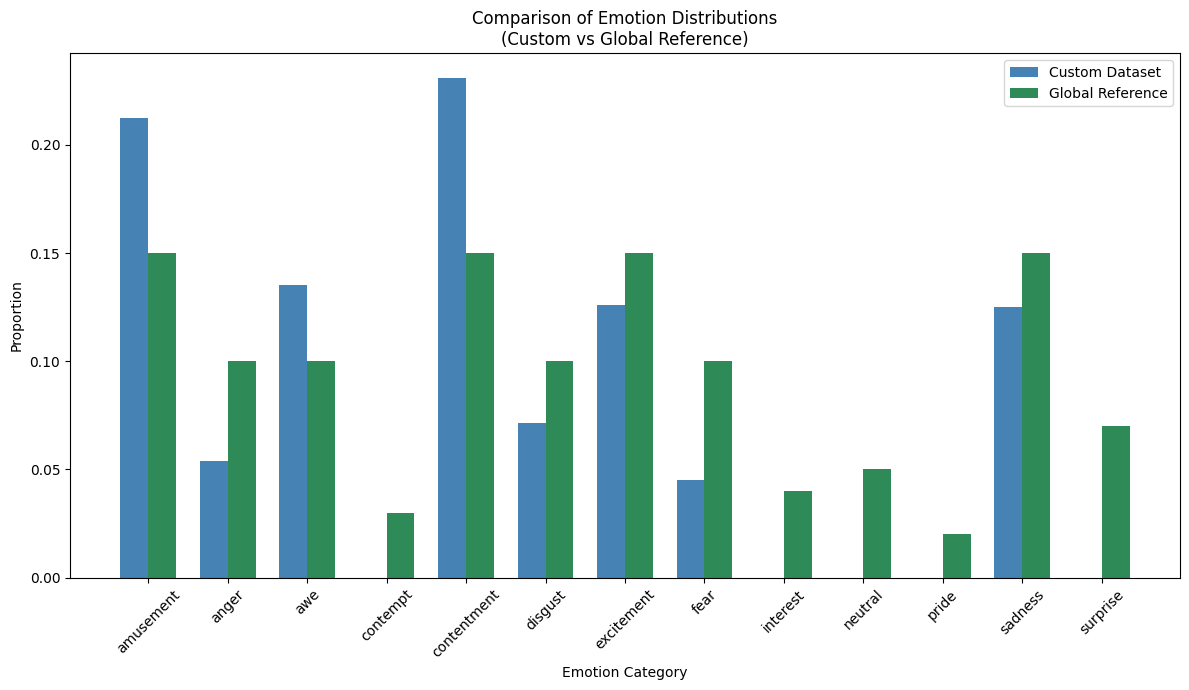

KL Divergence from global reference: 0.2667


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy  # for Kullback-Leibler divergence

# Assume `train_generator` is already defined and loaded (as in previous code)
# and train_generator.class_indices is mapping for your custom dataset.

# ----- Step 1: Calculate the distribution of emotion classes in your custom dataset -----
custom_counts = {}
for emotion, idx in train_generator.class_indices.items():
    # Count images that belong to a particular emotion using train_generator.classes.
    custom_counts[emotion] = np.sum(train_generator.classes == idx)

total_custom = np.sum(list(custom_counts.values()))
custom_distribution = {emotion: count / total_custom for emotion, count in custom_counts.items()}

print("Custom Dataset Distribution:")
for emotion, prop in custom_distribution.items():
    print(f"{emotion}: {prop:.2f}")

# ----- Step 2: Define a Global Reference Distribution -----
# Global reference distribution might include many emotion categories.
# The following is an example including additional categories beyond the 8 in your dataset.
global_distribution = {
    'amusement': 0.15,
    'anger': 0.10,
    'awe': 0.10,
    'contentment': 0.15,
    'disgust': 0.10,
    'excitement': 0.15,
    'fear': 0.10,
    'sadness': 0.15,
    'neutral': 0.05,
    'surprise': 0.07,
    'contempt': 0.03,
    'pride': 0.02,
    'interest': 0.04
}

print("\nGlobal Reference Distribution (example from literature):")
for emotion, prop in global_distribution.items():
    print(f"{emotion}: {prop:.2f}")

# ----- Step 3: Compare the Two Distributions -----
# Create the union of both emotion categories:
all_emotions = set(list(custom_distribution.keys()) + list(global_distribution.keys()))
all_emotions = sorted(all_emotions)  # sort for consistent plotting order

# For each emotion in the union, get the custom and global proportions,
# using 0 if an emotion category is not present in one of the distributions.
custom_props = [custom_distribution.get(emo, 0) for emo in all_emotions]
global_props = [global_distribution.get(emo, 0) for emo in all_emotions]

# Determine which emotions are present in your custom dataset and which are missing
custom_emotions = set(custom_distribution.keys())
global_emotions = set(global_distribution.keys())
missing_in_custom = global_emotions - custom_emotions
present_in_custom = global_emotions.intersection(custom_emotions)

print("\nEmotion categories present in your custom dataset:")
print(present_in_custom)
print("\nEmotion categories in global reference but missing from your custom dataset:")
print(missing_in_custom)

# Plot the distributions side-by-side
x = np.arange(len(all_emotions))
width = 0.35

plt.figure(figsize=(12, 7))
plt.bar(x - width/2, custom_props, width, label='Custom Dataset', color='steelblue')
plt.bar(x + width/2, global_props, width, label='Global Reference', color='seagreen')
plt.xticks(x, all_emotions, rotation=45)
plt.xlabel("Emotion Category")
plt.ylabel("Proportion")
plt.title("Comparison of Emotion Distributions\n(Custom vs Global Reference)")
plt.legend()
plt.tight_layout()
plt.show()

# ----- Step 4: Quantitative Comparison using Kullback-Leibler Divergence -----
custom_probs = np.array(custom_props)
global_probs = np.array(global_props)
kl_divergence = entropy(custom_probs, global_probs)
print(f"KL Divergence from global reference: {kl_divergence:.4f}")
